# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib inline
import pandas as pd
import tqdm
import numpy as np
from skimage.filters import threshold_otsu
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import glob

In [3]:
def palm_hist(df, yx_shape, subsampling=1):
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    return np.histogramdd(df[["y0", "x0"]].values, bins=bins)[0]

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [4]:
def remove_xy_mean(df):
    df_new = df.astype(np.float)
    xyz_mean = df_new[["z0", "y0", "x0"]].mean()
    df_new[["z0", "y0", "x0"]] -= xyz_mean
    return df_new

def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    if len(fiducials_df) == 1:
        return remove_xy_mean(fiducials_df[0])
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.x0.plot(ax=ax0)
            ff.y0.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        wm = lambda group: np.average(group, weights=df_means.loc[group.index, weighted])
    else:
        wm = "mean"
    return df_means.groupby("frame").agg({"x0" : wm, "y0" : wm, "z0" : wm})

def remove_drift(df_data, drift):
    # make our index frame number so that when we subtract drift it aligns automatically along
    # the index, this needs to be tested.
    # this also, conveniently, makes a copy of the data
    df_data_dc = df_data.set_index("frame")
    # subtract drift only (assumes that drift only has these keys)
    df_data_dc[["x0", "y0", "z0"]] -= drift
    # return the data frame with the index reset so that all localizations have
    # a unique id
    return df_data_dc.reset_index()

In [5]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["x0", "y0","z0", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift", "zdrift"]] = pd.DataFrame([f.agg({"x0":fwhm,"y0":fwhm, "z0":fwhm}) for
                                                    f in fid_df_list])[["x0","y0", "z0"]]
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["x0","y0", "z0"]] - f[["x0","y0", "z0"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, blobs, radius, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.x0 - x) ** 2 + (df.y0 - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('frame').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [6]:
def plot_stats(fids_df):
    fid, drift = calc_fiducial_stats(fids_df)
    drift[["x0","y0"]] *= 130
    fid[["x0", "xdrift", "y0", "ydrift", "sigma"]] *= 130
    fid.sort_values("sigma").reset_index().plot(subplots=True)
    fid.hist(bins=32)
    drift.hist(bins=64, normed=True, layout=(3,1), figsize=(3, 9))
#     pd.plotting.table(plt.gca(), np.round(drift.describe(), 2), loc='upper right', colWidths=[0.2, 0.2, 0.2])
    print(drift.std() * 2 * np.sqrt(2 * np.log(2)))

In [7]:
data_dict = {path:pd.read_hdf(path) for path in glob.iglob("*.h5")}

In [8]:
# jury-rigged
for k, v in data_dict.items():
    v["z0"] = (v["sigma_x"] - v["sigma_y"]) / (v["sigma_x"] + v["sigma_y"])

In [9]:
%time hists = {k:palm_hist(v, (512, 512)) for k, v in data_dict.items()}

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [11]:
from dphplotting import display_grid

(<matplotlib.figure.Figure at 0x2600c16e6d8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002600C173A90>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000002600AE17278>]], dtype=object))

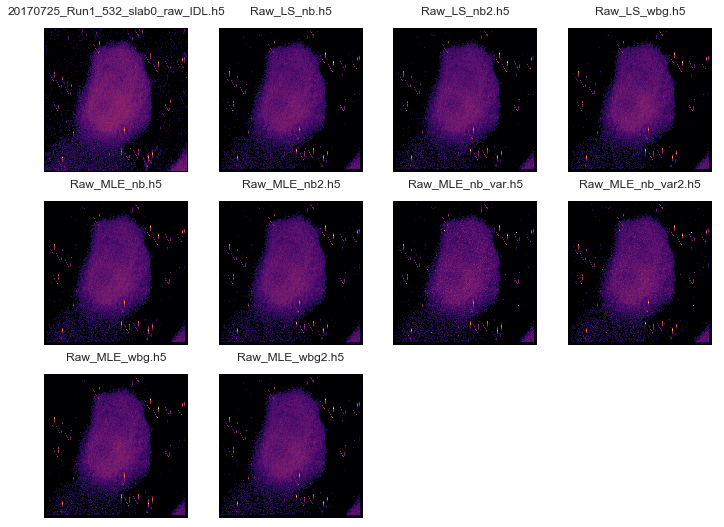

In [13]:
display_grid(hists, cmap="inferno", norm=PowerNorm(0.25))

In [14]:
pf = PeakFinder(v, 20, 200)

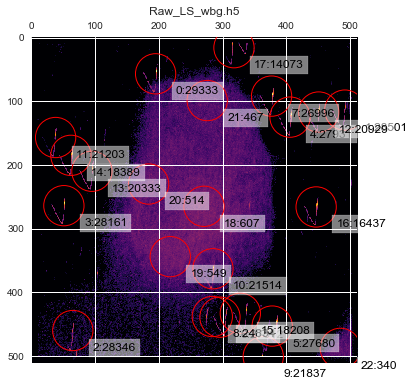

In [15]:
pf.find_blobs()
pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.25))
plt.title(k)

In [16]:
initial_fid = extract_fiducials(data_dict[k], [pf.blobs[16, :2]], 40)

In [17]:
initial_drift = calc_drift(initial_fid)

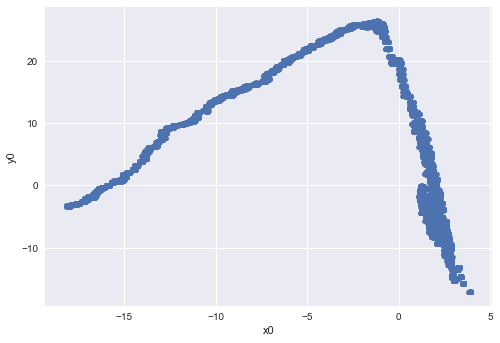

In [18]:
initial_drift.plot.scatter("x0","y0")

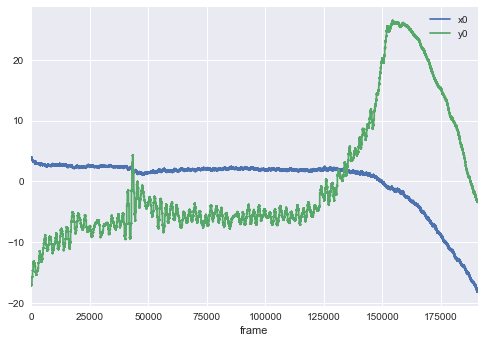

In [19]:
initial_drift[["x0", "y0"]].plot()

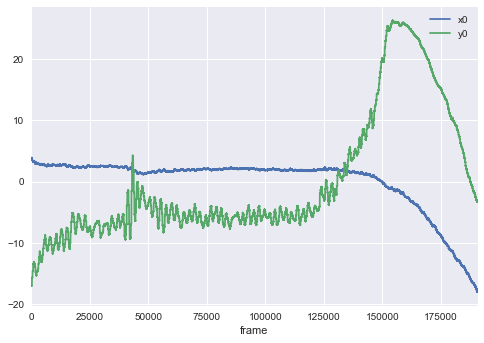

In [20]:
initial_drift[["x0", "y0"]].rolling(10, 0, center=True).median().plot()

In [21]:
data_dc = {k:remove_drift(v, initial_drift) for k, v in tqdm.tqdm_notebook(data_dict.items())}

In [22]:
hists_dc = {k:palm_hist(v, (512, 512), 0.1) for k, v in tqdm.tqdm_notebook(data_dc.items())}

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


(<matplotlib.figure.Figure at 0x260108c4c88>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000260108B17B8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000002601133F908>]], dtype=object))

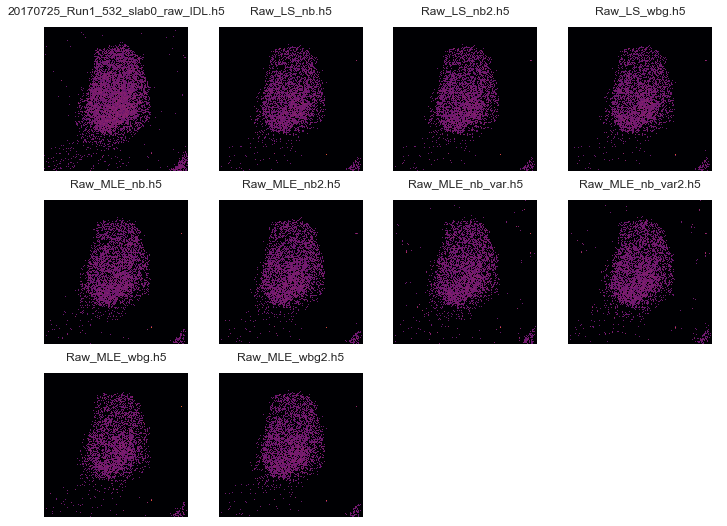

In [24]:
display_grid(hists_dc, cmap="inferno", norm=PowerNorm(0.1))

In [25]:
def find_fiducials(df, yx_shape, subsampling=1):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.frame.max() - df.frame.min()
    hist_2d = palm_hist(df, yx_shape, subsampling)
    pf = PeakFinder(hist_2d, 1)
    pf.blob_sigma = 1/subsampling
    # no blobs found so try again with a lower threshold
    pf.thresh = 0
    pf.find_blobs()
    blob_thresh = max(threshold_otsu(pf.blobs[:, 3]), num_frames / 10)
    if not pf.blobs.size:
        # still no blobs then raise error
        raise RuntimeError("No blobs found!")
    pf.blobs = pf.blobs[pf.blobs[:,3] > blob_thresh]
    if pf.blobs[:, 3].max() < num_frames * subsampling / 2:
        print("Warning, drift maybe too high to find fiducials")
    # correct positions for subsampling
    pf.blobs[:, :2] = pf.blobs[:, :2] * subsampling
    return pf

In [26]:
for k,v in data_dc.items(): pass
test_fid = find_fiducials(v, (512, 512))

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


(<matplotlib.figure.Figure at 0x260113c6d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x260113e2128>)

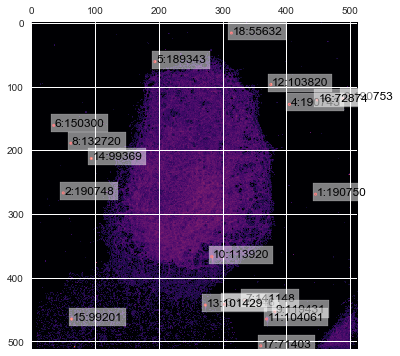

In [27]:
test_fid.plot_blobs(cmap="inferno", norm=PowerNorm(0.2))

In [28]:
test_fid_df = extract_fiducials(v, test_fid.blobs[:,:2], 2)

x0    34.322998
y0    56.557227
z0     0.113937
dtype: float64


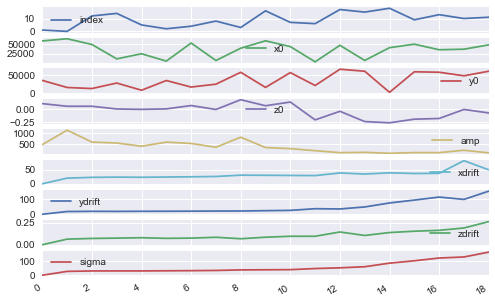

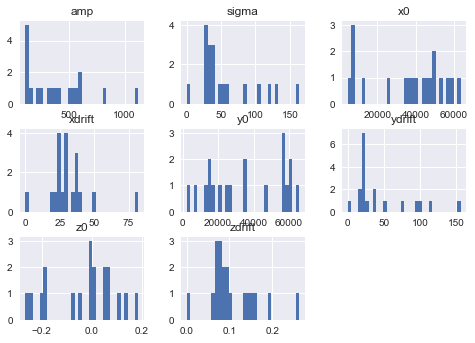

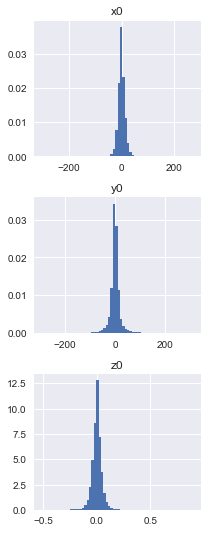

In [29]:
plot_stats(test_fid_df)

In [30]:
test_fid_stats, test_fid_drift = calc_fiducial_stats(test_fid_df)

'Raw_LS_wbg.h5'

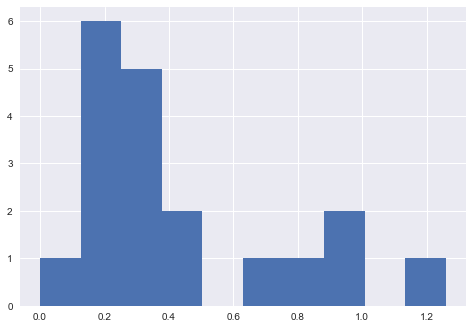

In [31]:
fig, ax = plt.subplots()
test_fid_stats.sigma.hist(ax=ax)
k

In [33]:
good_fid = test_fid_stats[test_fid_stats.sigma < 0.3]
len(good_fid)

10

In [34]:
good_fid

,x0,y0,z0,amp,xdrift,ydrift,zdrift,sigma
0,489.068918,119.057927,0.057797,1122.610397,1.537591e-01,1.421122e-01,6.413267e-02,2.093747e-01
1,445.533650,269.310425,0.109478,488.862088,1.599985e-09,1.544703e-09,7.313734e-13,2.223974e-09
2,49.800801,266.966646,0.006760,597.043010,1.845995e-01,1.562335e-01,7.304317e-02,2.418385e-01
3,302.942609,442.174133,0.185811,814.096283,2.351372e-01,1.694335e-01,6.849113e-02,2.898227e-01
4,404.810323,128.149778,0.071912,538.222287,1.903551e-01,1.607859e-01,7.567216e-02,2.491729e-01
5,193.907937,60.668745,-0.002838,417.045864,1.774491e-01,1.542437e-01,8.005818e-02,2.351155e-01
8,61.555867,189.377692,-0.004864,370.228446,1.993545e-01,1.671858e-01,8.531398e-02,2.601794e-01
12,376.213305,96.507760,0.058195,599.642269,1.752290e-01,1.526003e-01,7.191920e-02,2.323619e-01
14,93.582390,213.483814,0.004899,558.622472,1.818341e-01,1.484744e-01,7.548761e-02,2.347515e-01
16,448.579131,120.517183,0.067811,358.133615,2.319380e-01,1.860265e-01,8.593756e-02,2.973232e-01


In [35]:
for k, v in data_dc.items():
    v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12843591 entries, 0 to 12843590
Data columns (total 16 columns):
frame        int64
SNR          float64
amp          float64
amp_e        float64
noise        float64
offset       float64
offset_e     float64
sigma_x      float64
sigma_x_e    float64
sigma_y      float64
sigma_y_e    float64
x0           float64
x0_e         float64
y0           float64
y0_e         float64
z0           float64
dtypes: float64(15), int64(1)
memory usage: 1.5 GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12842842 entries, 0 to 12842841
Data columns (total 16 columns):
frame        int64
SNR          float64
amp          float64
amp_e        float64
noise        float64
offset       float64
offset_e     float64
sigma_x      float64
sigma_x_e    float64
sigma_y      float64
sigma_y_e    float64
x0           float64
x0_e         float64
y0           float64
y0_e         float64
z0           float64
dtypes: float64(15), int64(1)
memory usage: 1.5 GB


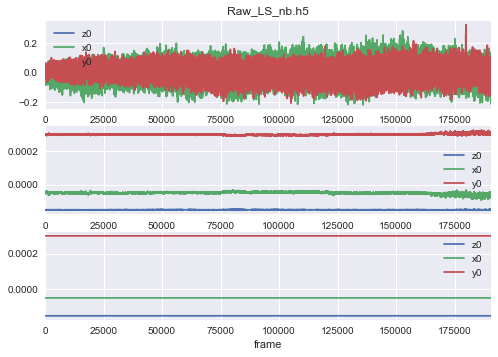

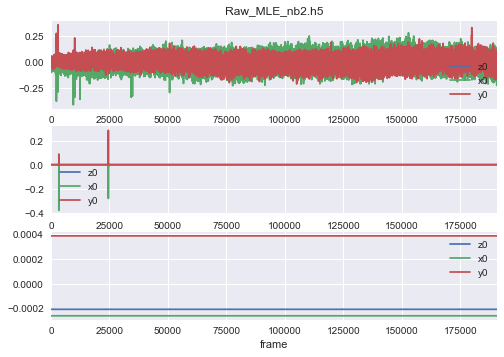

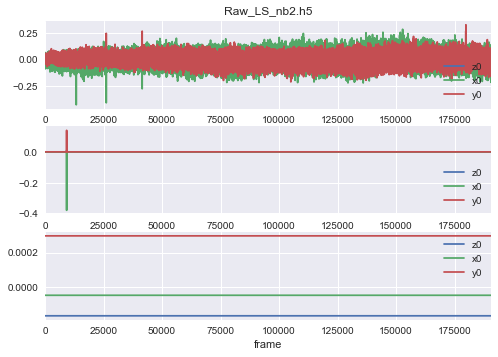

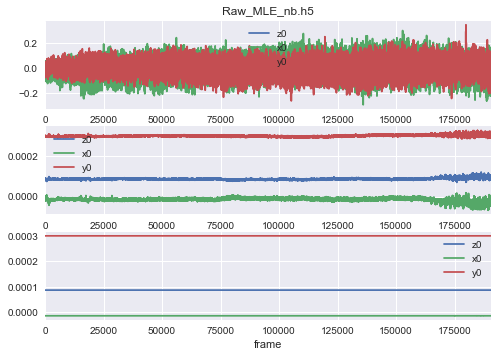

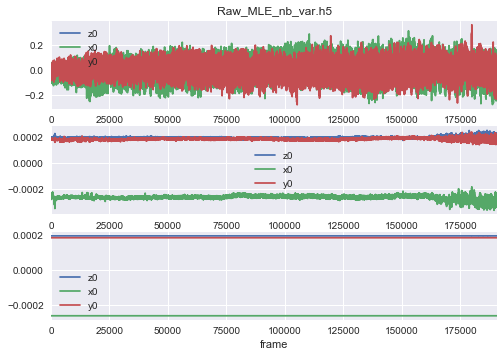

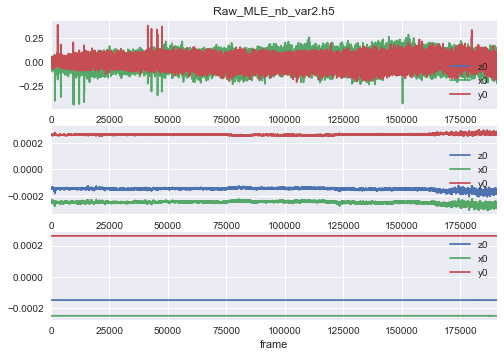

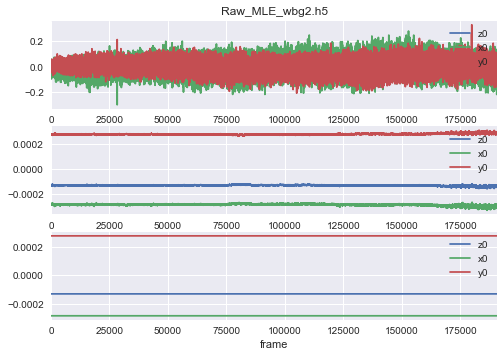

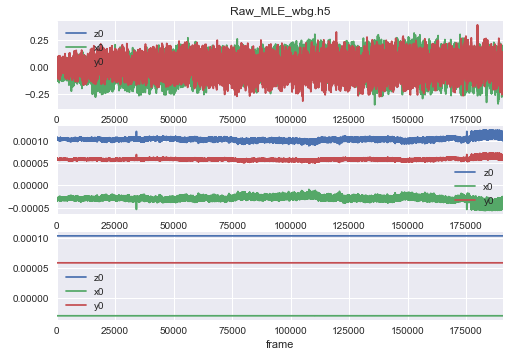

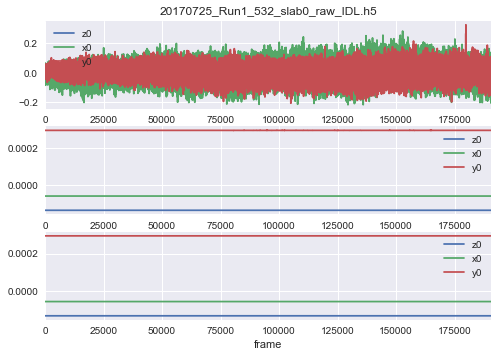

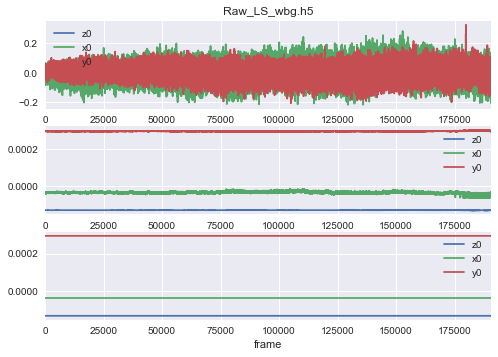

In [36]:
data_dc2 = {}
for k, v in data_dc.items():
    fig, axs = plt.subplots(3)
    for ax in axs[:2]:
        corr_fids = extract_fiducials(v, good_fid[["y0","x0"]].values, 2)
        corr_drift = calc_drift(corr_fids)
        corr_drift.plot(ax=ax)
        data_dc2[k] = v = remove_drift(v, corr_drift)
    corr_drift2=calc_drift(extract_fiducials(v, good_fid[["y0","x0"]].values, 2))
    corr_drift2.plot(ax=axs[-1])
    axs[0].set_title(k)

In [37]:
stats_dc2 = {}
for k, v in data_dc2.items():
    fid_stats, all_drift = calc_fiducial_stats(extract_fiducials(v, good_fid[["y0","x0"]].values, 2))
    stats_dc2[k] = dict(fid_stats=fid_stats, all_drift=all_drift)

In [41]:
for k, v in sorted(stats_dc2.items()):
    print(k)
    print(v["all_drift"].std() * 130 * 2 * np.sqrt(2 * np.log(2)))

20170725_Run1_532_slab0_raw_IDL.h5
x0    17.745395
y0    15.277119
z0     6.547852
dtype: float64
Raw_LS_nb.h5
x0    17.670149
y0    15.183675
z0     6.520874
dtype: float64
Raw_LS_nb2.h5
x0    17.625319
y0    15.123942
z0     6.482355
dtype: float64
Raw_LS_wbg.h5
x0    17.707309
y0    15.259778
z0     6.538281
dtype: float64
Raw_MLE_nb.h5
x0    36.034848
y0    30.562826
z0     2.908876
dtype: float64
Raw_MLE_nb2.h5
x0    17.350736
y0    14.002014
z0     6.052593
dtype: float64
Raw_MLE_nb_var.h5
x0    40.322922
y0    34.625230
z0     3.205534
dtype: float64
Raw_MLE_nb_var2.h5
x0    18.163995
y0    15.096443
z0     7.196891
dtype: float64
Raw_MLE_wbg.h5
x0    58.381507
y0    54.146453
z0     1.611710
dtype: float64
Raw_MLE_wbg2.h5
x0    16.957211
y0    14.255468
z0     6.049096
dtype: float64


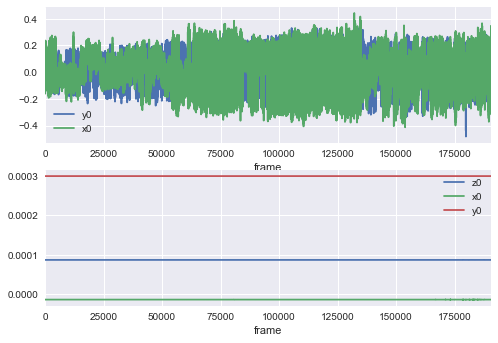

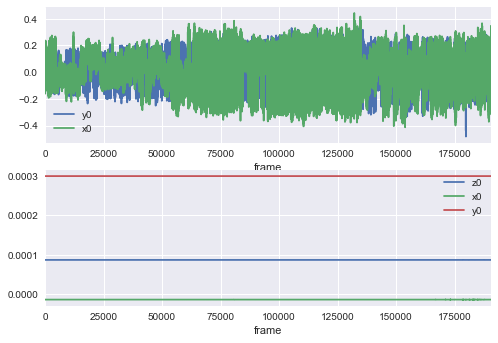

In [40]:
for k in ("Raw_MLE_nb.h5", "Raw_MLE_nb2.h5"):
    fig, (ax0, ax1) = plt.subplots(2)
    test_fid_MLE = extract_fiducials(data_dc2["Raw_MLE_nb.h5"], good_fid[["y0","x0"]].values, 2)
    test_fid_MLE_nomean = [remove_xy_mean(ff) for ff in test_fid_MLE]
    test_fid_MLE_nomean[1][["y0","x0"]].plot(ax=ax0)
    test_fid_MLE_drift = calc_drift(test_fid_MLE)
    test_fid_MLE_drift.plot(ax=ax1)

